In [1]:
import pandas as pd
from datetime import datetime
from datetime import timedelta
import pyspark.sql.functions as func
import numpy as np
from scipy import sparse
from numpy import array
import timeit

%matplotlib inline
import matplotlib.pylab as plt

In [2]:
import pyspark
from pyspark.sql import SparkSession
import os
import getpass
from pyspark.streaming import StreamingContext
from  pyspark.streaming.kafka import KafkaUtils, OffsetRange

username = getpass.getuser()

# Use this when running on the cluster
os.environ['PYSPARK_PYTHON'] = '/opt/anaconda3/bin/python'
spark = (SparkSession
         .builder
         .appName('streaming-{0}'.format(username))
         .master('yarn')
         .config('spark.executor.memory', '1g')
         .config('spark.executor.instances', '2')
         .config('spark.executor.cores', '2')
         .config('spark.jars.packages', 'org.apache.spark:spark-streaming-kafka-0-8_2.11:2.3.2')
         .getOrCreate())

sc = spark.sparkContext
conf = sc.getConf()

spark

In [3]:
# builds path for file given date as parameter
def format_path(path, year, month, day):
    d = day
    m = month
    if(d < 10):
        d = '0' + str(d)
    if(m < 10):
        m = '0' + str(m)
    return path.format(year, m, year, m, d)

format_path('/datasets/sbb/{}/{}/{}-{}-{}istdaten.csv.bz2', 2018, 9, 2)

'/datasets/sbb/2018/09/2018-09-02istdaten.csv.bz2'

In [4]:
# imports files for given day and the day following the parameter given
# returns rdd
def import_today_tomorrow(today):
    dummy_path = '/datasets/sbb/{}/{}/{}-{}-{}istdaten.csv.bz2'
    tomorrow = today + timedelta(days = 1)
    path_today = format_path(dummy_path, today.year, today.month, today.day)
    path_tomorrow = format_path(dummy_path, tomorrow.year, tomorrow.month, tomorrow.day)
    
    raw = spark.read.load([path_today, path_tomorrow],
                        format = 'csv', 
                        header = True,
                        sep = ';')
    return raw
import_today_tomorrow(pd.Timestamp('2018-02-18'))

DataFrame[BETRIEBSTAG: string, FAHRT_BEZEICHNER: string, BETREIBER_ID: string, BETREIBER_ABK: string, BETREIBER_NAME: string, PRODUKT_ID: string, LINIEN_ID: string, LINIEN_TEXT: string, UMLAUF_ID: string, VERKEHRSMITTEL_TEXT: string, ZUSATZFAHRT_TF: string, FAELLT_AUS_TF: string, BPUIC: string, HALTESTELLEN_NAME: string, ANKUNFTSZEIT: string, AN_PROGNOSE: string, AN_PROGNOSE_STATUS: string, ABFAHRTSZEIT: string, AB_PROGNOSE: string, AB_PROGNOSE_STATUS: string, DURCHFAHRT_TF: string]

In [6]:
# new names for the existing features
new_columns = ['trip_date', 'trip_id', 'op_id', 'op_abk', 'op_name', 'transport_type', 'train_number', 'service_type_1',\
               'umlauf_id', 'service_type_2', 'is_additional', 'trip_failed', 'bpuic', 'stop_name', 'sch_arr_time', \
              'real_arr_time', 'on_time_arr', 'sch_dep_time', 'real_dep_time', 'on_time_dep', 'stop_at_station']

In [7]:
# columns relevant for the path-finding algorithm
useful_columns = ['trip_id', 'service_type_1', 'stop_name', 'sch_arr_time', 'real_arr_time', 'on_time_arr', \
                 'sch_dep_time', 'real_dep_time', 'on_time_dep']

In [8]:
# renames columns in english names
# parses timestamps for trip_date and scheduled times
# removes samples for which the trip does not stop
# removes samples for which there is not at least one arrival and departure time (it be scheduled or observed)
def pre_process(raw):
    raw = raw.toDF(*new_columns)
    # parse timestamp
    raw = raw.withColumn('trip_date', func.to_timestamp(raw.trip_date, 'dd.MM.yyyy').alias('trip_date'))
    # remove trains that do not stop
    raw = raw.filter(func.col('stop_at_station')=='false').drop('stop_at_station')
    # Keep only trips that have at least one arrival and departure time
    raw = raw.filter((func.col('sch_arr_time').isNotNull() | func.col('real_arr_time').isNotNull()) & \
                     (func.col('sch_dep_time').isNotNull() | func.col('real_dep_time').isNotNull())
                    )
    # parse scheduled arrival and departure times
    raw = raw.withColumn('sch_arr_time', func.to_timestamp(raw.sch_arr_time, 'dd.MM.yyyyHH:mm').alias('sch_arr_time'))
    raw = raw.withColumn('sch_dep_time', func.to_timestamp(raw.sch_dep_time, 'dd.MM.yyyy HH:mm').alias('sch_dep_time'))
    
    # compute list of trips that appear more than once THIS IS SLOW, should try to do it on main data
    invalid_ids = raw.groupBy('trip_id').agg(func.count('*').alias('trip_id_counts')).filter(func.col('trip_id_counts')<=1)
    # put it as a list
    invalid_ids = invalid_ids.select('trip_id').distinct().rdd.map(lambda r: r[0]).collect()
    # remove trips for which there is only a single sample
    raw = raw.where(raw.trip_id.isin(invalid_ids) == False)
    return raw

pre_process(import_today_tomorrow(pd.Timestamp('2018-02-18')))

DataFrame[trip_date: timestamp, trip_id: string, op_id: string, op_abk: string, op_name: string, transport_type: string, train_number: string, service_type_1: string, umlauf_id: string, service_type_2: string, is_additional: string, trip_failed: string, bpuic: string, stop_name: string, sch_arr_time: timestamp, real_arr_time: string, on_time_arr: string, sch_dep_time: timestamp, real_dep_time: string, on_time_dep: string]

In [9]:
df = pre_process(import_today_tomorrow(pd.Timestamp('2018-02-18')))

In [10]:
df_bpuics = df.select('bpuic').distinct().collect()
df_bpuics[:5]

[Row(bpuic='8502128'),
 Row(bpuic='8501469'),
 Row(bpuic='8591190'),
 Row(bpuic='8505578'),
 Row(bpuic='8506024')]

In [11]:
geo_data = pd.read_csv('geo_stops_data.csv', sep=';')
geo_data.head(2)

,bpuic,y_Coord_Est,x_Coord_Nord
0,8508186,628463,220751
1,8587698,643683,132003


Text(0.5, 1.0, 'positions')

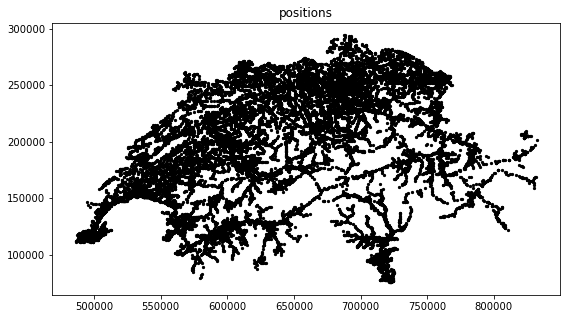

In [12]:
plt.figure(figsize=(20,5))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black'])
 
# Plot Sepal
plt.subplot(1, 2, 1)
plt.scatter(geo_data.y_Coord_Est, geo_data.x_Coord_Nord, c='black', s=5)
plt.title('positions')

2
4
6
8


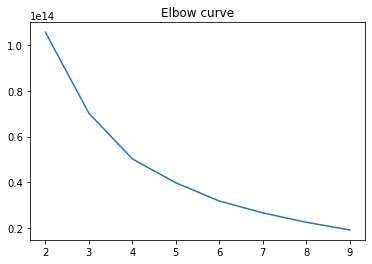

In [13]:
from sklearn.cluster import KMeans

df_kmeans = geo_data[['y_Coord_Est', 'x_Coord_Nord']]

k_max = 10

cost = np.zeros(k_max)

for k in range(2,k_max):
    if(k % 2 == 0):
        print(k)
    model = KMeans(n_clusters = k)
    model = model.fit(df_kmeans)
    cost[k] = -model.score(df_kmeans)


plt.plot(range(2,k_max),cost[2:k_max])
plt.title('Elbow curve');

Text(0.5, 1.0, 'positions')

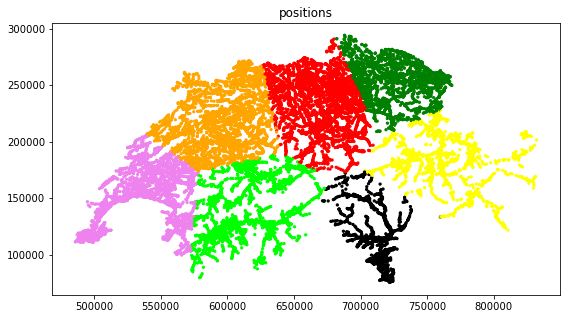

In [14]:
num_clusters = 7
model = KMeans(n_clusters = num_clusters)
model = model.fit(df_kmeans)

labels = model.labels_

plt.figure(figsize=(20,5))
 
# Create a colormap
colormap = np.array(['red', 'lime', 'black', 'yellow', 'orange', 'green', 'violet', 'blue'])
 
# Plot Sepal
plt.subplot(1, 2, 1)
plt.scatter(geo_data.y_Coord_Est, geo_data.x_Coord_Nord, c=colormap[labels], s=5)
plt.title('positions')

In [15]:
geo_data['cluster'] = labels
center_y = geo_data.groupby('cluster').apply(lambda x: x['y_Coord_Est'].mean())
center_x = geo_data.groupby('cluster').apply(lambda x: x['x_Coord_Nord'].mean())

In [16]:
cluster_centers = pd.DataFrame(round(center_x,2)).rename(columns={0:'x'})
cluster_centers['y'] = round(center_y, 2).values
cluster_centers

,x,y
cluster,,
0,235088.46,671579.45
1,140900.72,615905.16
2,112997.77,711988.28
3,185329.95,763294.77
4,221127.46,595557.14
5,254539.14,725071.36
6,147090.84,536266.62


In [17]:
def eucl_dist(row1, row2, col1r1, col2r1, col1r2, col2r2):
    dx = row1[col1r1] - row2[col1r2]
    dy = row1[col2r1] - row2[col2r2]
    return np.sqrt(dx*dx + dy*dy)

In [18]:
geo_data['dist_to_center'] = geo_data.apply(lambda row: eucl_dist(row, cluster_centers.loc[row['cluster']],
                                                                  'x_Coord_Nord', 'y_Coord_Est', 'x', 'y'), axis=1)
for iClust in range(num_clusters):
    geo_data['dist_to_center_{}'.format(iClust)] = geo_data.apply(lambda row: eucl_dist(row, cluster_centers.loc[iClust],
                                                                            'x_Coord_Nord', 'y_Coord_Est', 'x', 'y'), axis=1)

is_in_ratio = 2
for iClust in range(num_clusters):
    geo_data['is_in_{}'.format(iClust)] = geo_data.apply(lambda row: \
                                        row['dist_to_center']*is_in_ratio > row['dist_to_center_{}'.format(iClust)], axis=1)
    geo_data.drop('dist_to_center_{}'.format(iClust), axis=1, inplace= True)

In [19]:
geo_data.head(10)

,bpuic,y_Coord_Est,x_Coord_Nord,cluster,dist_to_center,is_in_0,is_in_1,is_in_2,is_in_3,is_in_4,is_in_5,is_in_6
0,8508186,628463,220751,4,32908.013378,True,False,False,False,True,False,False
1,8587698,643683,132003,1,29168.095863,False,True,False,False,False,False,False
2,8531188,613319,109828,1,31180.156378,False,True,False,False,False,False,False
3,8530051,572770,129980,6,40314.731761,False,True,False,False,False,False,True
4,8501442,650331,141959,1,34442.102379,False,True,True,False,False,False,False
5,8583656,584548,246664,4,27808.560529,False,False,False,False,True,False,False
6,8590028,599934,200621,4,20968.352467,False,False,False,False,True,False,False
7,8579143,509845,163459,6,31080.840806,False,False,False,False,False,False,True
8,8572195,599991,249781,4,28994.559301,False,False,False,False,True,False,False
9,8576536,643212,163308,1,35323.500786,False,True,False,False,False,False,False


In [20]:
missing_bpuics = list(set(df_bpuics) - set(map(lambda x: int(x),geo_data.index)))
missing_bpuics[:5]

[Row(bpuic='8571600'),
 Row(bpuic='8507172'),
 Row(bpuic='8589808'),
 Row(bpuic='8501605'),
 Row(bpuic='8590203')]